# Information Extraction with Haystack and NuExtract

*Authored by: [Stefano Fiorucci](https://github.com/anakin87)*

In this notebook, we will see how to automate Information Extraction from textual data using Language Models.

🎯 Goal: create an application to extract specific information from a given text or URL, following a user-defined structure.

🧰 **Stack**
- [Haystack 🏗️](https://haystack.deepset.ai?utm_campaign=developer-relations&utm_source=hf-cookbook): a customizable orchestration framework for building LLM applications. We will use Haystack to build the Information Extraction Pipeline.

- [NuExtract](https://huggingface.co/numind/NuExtract): a small Language Model, specifically fine-tuned for structured data extraction.

## Install dependencies

In [1]:
! pip install haystack-ai trafilatura transformers pyvis

## Components

Haystack has two main concepts: [Components and Pipelines](https://docs.haystack.deepset.ai/docs/components_overview?utm_campaign=developer-relations&utm_source=hf-cookbook).

🧩 **Components** are building blocks that perform a single task: file conversion, text generation, embedding creation...

➿ **Pipelines** allow you to define the flow of data through your LLM application, by combining Components in a directed (cyclic) graph.

*We will now introduce the various components of our Information Extraction application. Afterwards, we will integrate them into a Pipeline.*

### `LinkContentFetcher` and `HTMLToDocument`: extract text from web pages

In our experiment, we will extract data from startup funding announcements found on the web.

To download web pages and extract text, we use two components:
- [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher?utm_campaign=developer-relations&utm_source=hf-cookbook): fetches the content of some URLs and returns a list of content streams (as [`ByteStream` objects](https://docs.haystack.deepset.ai/docs/data-classes#bytestream?utm_campaign=developer-relations&utm_source=hf-cookbook)).
- [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument?utm_campaign=developer-relations&utm_source=hf-cookbook): converts HTML sources into textual [`Documents`](https://docs.haystack.deepset.ai/docs/data-classes#document?utm_campaign=developer-relations&utm_source=hf-cookbook).

In [2]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument


fetcher = LinkContentFetcher()

streams = fetcher.run(urls=["https://example.com/"])["streams"]

converter = HTMLToDocument()
docs = converter.run(sources=streams)

print(docs)

{'documents': [Document(id=65bb1ce4b6db2f154d3acfa145fa03363ef93f751fb8599dcec3aaf75aa325b9, content: 'This domain is for use in illustrative examples in documents. You may use this domain in literature ...', meta: {'content_type': 'text/html', 'url': 'https://example.com/'})]}


### `HuggingFaceLocalGenerator`: load and try the model

We use the [`HuggingFaceLocalGenerator`](https://docs.haystack.deepset.ai/docs/huggingfacelocalgenerator?utm_campaign=developer-relations&utm_source=hf-cookbook), a text generation component that allows loading a model hosted on Hugging Face using the Transformers library.

Haystack supports many other [Generators](https://docs.haystack.deepset.ai/docs/generators?utm_campaign=developer-relations&utm_source=hf-cookbook), including [`HuggingFaceAPIGenerator`](https://docs.haystack.deepset.ai/docs/huggingfaceapigenerator?utm_campaign=developer-relations&utm_source=hf-cookbook) (compatible with Hugging Face APIs and TGI).

We load [NuExtract](https://huggingface.co/numind/NuExtract), a model fine-tuned from `microsoft/Phi-3-mini-4k-instruct` to perform structured data extraction from text. The model size is 3.8B parameters. Other variants are also available: `NuExtract-tiny` (0.5B) and `NuExtract-large` (7B).

The model is loaded with `bfloat16` precision to fit in Colab with negligible performance loss compared to FP32, as suggested in the model card.

#### Notes on Flash Attention

At inference time, you will probably see a warning saying: "You are not running the flash-attention implementation".

GPUs available on free environments like Colab or Kaggle do not support it, so we decided to not use it in this notebook.

In case your GPU architecture supports it ([details](https://github.com/Dao-AILab/flash-attention)), you can install it and get a speed-up as follows:
```bash
pip install flash-attn --no-build-isolation
```

Then add `"attn_implementation": "flash_attention_2"` to `model_kwargs`.

In [3]:
from haystack.components.generators import HuggingFaceLocalGenerator
import torch

generator = HuggingFaceLocalGenerator(model="numind/NuExtract",
                                      huggingface_pipeline_kwargs={"model_kwargs": {"torch_dtype":torch.bfloat16}})

# effectively load the model (warm_up is automatically invoked when the generator is part of a Pipeline)
generator.warm_up()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/986 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/394M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/334 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

The model supports a specific prompt structure, as can be inferred from the model card.

Let's manually create a prompt to try the model. Later, we will see how to dynamically create the prompt based on different inputs.

In [4]:
prompt="""<|input|>\n### Template:
{
    "Car": {
        "Name": "",
        "Manufacturer": "",
        "Designers": [],
        "Number of units produced": "",
    }
}
### Text:
The Fiat Panda is a city car manufactured and marketed by Fiat since 1980, currently in its third generation. The first generation Panda, introduced in 1980, was a two-box, three-door hatchback designed by Giorgetto Giugiaro and Aldo Mantovani of Italdesign and was manufactured through 2003 — receiving an all-wheel drive variant in 1983. SEAT of Spain marketed a variation of the first generation Panda under license to Fiat, initially as the Panda and subsequently as the Marbella (1986–1998).

The second-generation Panda, launched in 2003 as a 5-door hatchback, was designed by Giuliano Biasio of Bertone, and won the European Car of the Year in 2004. The third-generation Panda debuted at the Frankfurt Motor Show in September 2011, was designed at Fiat Centro Stilo under the direction of Roberto Giolito and remains in production in Italy at Pomigliano d'Arco.[1] The fourth-generation Panda is marketed as Grande Panda, to differentiate it with the third-generation that is sold alongside it. Developed under Stellantis, the Grande Panda is produced in Serbia.

In 40 years, Panda production has reached over 7.8 million,[2] of those, approximately 4.5 million were the first generation.[3] In early 2020, its 23-year production was counted as the twenty-ninth most long-lived single generation car in history by Autocar.[4] During its initial design phase, Italdesign referred to the car as il Zero. Fiat later proposed the name Rustica. Ultimately, the Panda was named after Empanda, the Roman goddess and patroness of travelers.
<|output|>
"""

result = generator.run(prompt=prompt)
print(result)

{'replies': ['{\n    "Car": {\n        "Name": "Fiat Panda",\n        "Manufacturer": "Fiat",\n        "Designers": [\n            "Giorgetto Giugiaro",\n            "Aldo Mantovani",\n            "Giuliano Biasio",\n            "Roberto Giolito"\n        ],\n        "Number of units produced": "over 7.8 million"\n    }\n}\n']}


Nice ✅

### `PromptBuilder`: dynamically create prompts

The [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=hf-cookbook) is initialized with a Jinja2 prompt template and renders it by filling in parameters passed through keyword arguments.

Our prompt template reproduces the structure shown in [model card](https://huggingface.co/numind/NuExtract).

During our experiments, we discovered that indenting the schema is particularly important to ensure good results. This probably stems from how the model was trained.

In [5]:
from haystack.components.builders import PromptBuilder
from haystack import Document

prompt_template = '''<|input|>
### Template:
{{ schema | tojson(indent=4) }}
{% for example in examples %}
### Example:
{{ example | tojson(indent=4) }}\n
{% endfor %}
### Text
{{documents[0].content}}
<|output|>
'''

prompt_builder = PromptBuilder(template=prompt_template)

In [6]:
example_document = Document(content="The Fiat Panda is a city car...")

example_schema = {
    "Car": {
        "Name": "",
        "Manufacturer": "",
        "Designers": [],
        "Number of units produced": "",
    }
}

prompt=prompt_builder.run(documents=[example_document], schema=example_schema)["prompt"]

print(prompt)

<|input|>
### Template:
{
    "Car": {
        "Designers": [],
        "Manufacturer": "",
        "Name": "",
        "Number of units produced": ""
    }
}

### Text
The Fiat Panda is a city car...
<|output|>


Works well ✅

### `OutputAdapter`

You may have noticed that the result of the extraction is the first element of the `replies` list and consists of a JSON string.

We would like to have a dictionary for each source document.
To perform this transformation in a pipeline, we can use the [`OutputAdapter`](https://docs.haystack.deepset.ai/docs/outputadapter?utm_campaign=developer-relations&utm_source=hf-cookbook).

In [7]:
import json
from haystack.components.converters import OutputAdapter


adapter = OutputAdapter(template="""{{ replies[0]| replace("'",'"') | json_loads}}""",
                                         output_type=dict,
                                         custom_filters={"json_loads": json.loads})

print(adapter.run(**result))

{'output': {'Car': {'Name': 'Fiat Panda', 'Manufacturer': 'Fiat', 'Designers': ['Giorgetto Giugiaro', 'Aldo Mantovani', 'Giuliano Biasio', 'Roberto Giolito'], 'Number of units produced': 'over 7.8 million'}}}


## Information Extraction Pipeline

### Build the Pipeline

We can now [create our Pipeline](https://docs.haystack.deepset.ai/docs/creating-pipelines?utm_campaign=developer-relations&utm_source=hf-cookbook) by adding and connecting the individual components.

In [8]:
from haystack import Pipeline

ie_pipe = Pipeline()
ie_pipe.add_component("fetcher", fetcher)
ie_pipe.add_component("converter", converter)
ie_pipe.add_component("prompt_builder", prompt_builder)
ie_pipe.add_component("generator", generator)
ie_pipe.add_component("adapter", adapter)

ie_pipe.connect("fetcher", "converter")
ie_pipe.connect("converter", "prompt_builder")
ie_pipe.connect("prompt_builder", "generator")
ie_pipe.connect("generator", "adapter")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: HuggingFaceLocalGenerator
  - adapter: OutputAdapter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> adapter.replies (List[str])

In [9]:
# IN CASE YOU NEED TO RECREATE THE PIPELINE FROM SCRATCH, YOU CAN UNCOMMENT THIS CELL

# ie_pipe = Pipeline()
# ie_pipe.add_component("fetcher", LinkContentFetcher())
# ie_pipe.add_component("converter", HTMLToDocument())
# ie_pipe.add_component("prompt_builder", PromptBuilder(template=prompt_template))
# ie_pipe.add_component("generator", HuggingFaceLocalGenerator(model="numind/NuExtract",
#                                       huggingface_pipeline_kwargs={"model_kwargs": {"torch_dtype":torch.bfloat16}})
# )
# ie_pipe.add_component("adapter", OutputAdapter(template="""{{ replies[0]| replace("'",'"') | json_loads}}""",
#                                          output_type=dict,
#                                          custom_filters={"json_loads": json.loads}))

# ie_pipe.connect("fetcher", "converter")
# ie_pipe.connect("converter", "prompt_builder")
# ie_pipe.connect("prompt_builder", "generator")
# ie_pipe.connect("generator", "adapter")


Let's review our pipeline setup:

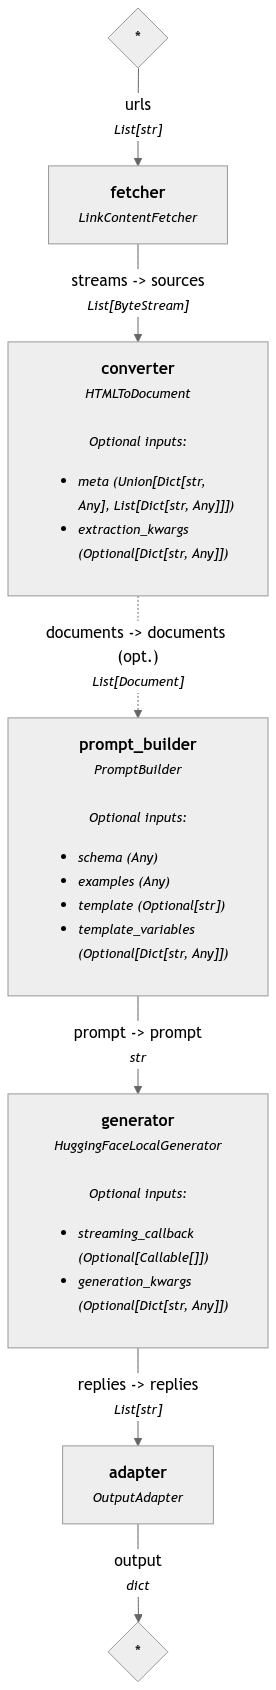

In [10]:
ie_pipe.show()

### Define the sources and the extraction schema

We select a list of URLs related to recent startup funding announcements.

Additionally, we define a schema for the structured information we aim to extract.

In [11]:
urls = ["https://techcrunch.com/2023/04/27/pinecone-drops-100m-investment-on-750m-valuation-as-vector-database-demand-grows/",
        "https://techcrunch.com/2023/04/27/replit-funding-100m-generative-ai/",
        "https://www.cnbc.com/2024/06/12/mistral-ai-raises-645-million-at-a-6-billion-valuation.html",
        "https://techcrunch.com/2024/01/23/qdrant-open-source-vector-database/",
        "https://www.intelcapital.com/anyscale-secures-100m-series-c-at-1b-valuation-to-radically-simplify-scaling-and-productionizing-ai-applications/",
        "https://techcrunch.com/2023/04/28/openai-funding-valuation-chatgpt/",
        "https://techcrunch.com/2024/03/27/amazon-doubles-down-on-anthropic-completing-its-planned-4b-investment/",
        "https://techcrunch.com/2024/01/22/voice-cloning-startup-elevenlabs-lands-80m-achieves-unicorn-status/",
        "https://techcrunch.com/2023/08/24/hugging-face-raises-235m-from-investors-including-salesforce-and-nvidia",
        "https://www.prnewswire.com/news-releases/ai21-completes-208-million-oversubscribed-series-c-round-301994393.html",
        "https://techcrunch.com/2023/03/15/adept-a-startup-training-ai-to-use-existing-software-and-apis-raises-350m/",
        "https://www.cnbc.com/2023/03/23/characterai-valued-at-1-billion-after-150-million-round-from-a16z.html"]


schema={
    "Funding": {
        "New funding": "",
        "Investors": [],
    },
     "Company": {
        "Name": "",
        "Activity": "",
        "Country": "",
        "Total valuation": "",
        "Total funding": ""
    }
}

### Run the Pipeline!

We pass the required data to each component.

Note that most of them receive data from previously executed components.

In [12]:
from tqdm import tqdm

extracted_data=[]

for url in tqdm(urls):
    result = ie_pipe.run({"fetcher":{"urls":[url]},
                          "prompt_builder": {"schema":schema}})

    extracted_data.append(result["adapter"]["output"])

100%|██████████| 12/12 [02:42<00:00, 13.58s/it]


Let's inspect some of the extracted data

In [13]:
extracted_data[:2]

[{'Company': {'Activity': 'AI-driven semantic search',
   'Country': '',
   'Name': 'Pinecone',
   'Total funding': '$138 million',
   'Total valuation': '$750 million'},
  'Funding': {'Investors': ['Andreessen Horowitz',
    'ICONIQ Growth',
    'Menlo Ventures',
    'Wing Venture Capital'],
   'New funding': '$100 million'}},
 {'Company': {'Activity': 'developing a code-generating AI-powered tool',
   'Country': 'San Francisco',
   'Name': 'Replit',
   'Total funding': 'over $200 million',
   'Total valuation': '$1.16 billion'},
  'Funding': {'Investors': ['Andreessen Horowitz',
    'Khosla Ventures',
    'Coatue',
    'SV Angel',
    'Y Combinator',
    'Bloomberg Beta',
    'Naval Ravikant',
    'ARK Ventures',
    'Hamilton Helmer'],
   'New funding': '$97.4 million'}}]

## Data exploration and visualization

Let's explore the extracted data to assess its correctness and gain insights.

### Dataframe

We start by creating a Pandas Dataframe. For simplicity, we flatten the extracted data.

In [14]:
def flatten_dict(d, parent_key=''):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key} - {k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key).items())
        elif isinstance(v, list):
            items.append((new_key, ', '.join(v)))
        else:
            items.append((new_key, v))
    return dict(items)

In [15]:
import pandas as pd

df = pd.DataFrame([flatten_dict(el) for el in extracted_data])
df = df.sort_values(by='Company - Name')

df

,Company - Activity,Company - Country,Company - Name,Company - Total funding,Company - Total valuation,Funding - Investors,Funding - New funding
9,AI systems for enterprise,Israel,AI21,$336 million,$1.4 billion,"Intel Capital, Comcast Ventures",$208 million
10,building AI that “enables humans and computers...,,Adept,$415 million,at least $1 billion,"General Catalyst, Spark Capital, Addition, Gre...",$350 million
6,growing AI power,,Anthropic,$1.25 billion,,"Amazon, Microsoft, Apple",$2.75 billion
4,enabling instant scaling of AI applications,USA,Anyscale,$160 million,$1 billion,"Andreessen Horowitz, Addition, NEA, Intel Capi...",$100 million
11,artificial intelligence,,Character.AI,$150 million,$1 billion,"Andreessen Horowitz, Nat Friedman, Elad Gil, A...",$150 million
7,voice AI research and product deployment,,ElevenLabs,$101 million,over $1 billion,"Andreessen Horowitz, Nat Friedman, Daniel Gros...",$80 million
8,data science hosting and development tools,France,Hugging Face,$395.2 million,$4.5 billion,"Google, Amazon, Nvidia, Intel, AMD, Qualcomm, ...",$235 million
2,building so-called large language models,France,Mistral AI,600 million euros,5.8 billion euros,"General Catalyst, Microsoft",600 million euros
5,AI,,OpenAI,just over $300 million,$27 billion – $29 billion,"Sequoia Capital, Andreessen Horowitz, Thrive, ...",just over $300 million
0,AI-driven semantic search,,Pinecone,$138 million,$750 million,"Andreessen Horowitz, ICONIQ Growth, Menlo Vent...",$100 million


![dataframe](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/haystack_dataframe.png)

Apart from some errors in "Company - Country", the extracted data looks good.

### Build a simple graph

To understand the relationships between companies and investors, we construct a graph and visualize it.

First, we build a graph using NetworkX.

[NetworkX](https://networkx.org/) is a Python package that allows to create and manipulate networks/graphs in a simple way.

Our simple graph will have companies and investors as nodes. We will connect investors to companies if they are mentioned in the same document.

In [16]:
import networkx as nx

# Create a new graph
G = nx.Graph()

# Add nodes and edges
for el in extracted_data:
    company_name = el["Company"]["Name"]
    G.add_node(company_name, label=company_name, title="Company")

    investors = el["Funding"]["Investors"]
    for investor in investors:
        if not G.has_node(investor):
            G.add_node(investor, label=investor, title="Investor", color="red")
        G.add_edge(company_name, investor)

Next, we use Pyvis to visualize the graph.

[Pyvis](https://pyvis.readthedocs.io/en/latest/) is a Python package for interactive visualization of networks/graphs. It integrates nicely with NetworkX.

In [17]:
from pyvis.network import Network
from IPython.display import display, HTML


net = Network(notebook=True, cdn_resources='in_line')
net.from_nx(G)

net.show('simple_graph.html')
display(HTML('simple_graph.html'))

simple_graph.html


![graph visualization](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/haystack_graph.png)

Looks like Andreessen Horowitz is quite present in the selected funding announcements 😊

## Conclusion and ideas

In this notebook, we demonstrated how to set up an information extraction system using a small language model (NuExtract) and Haystack, a customizable orchestration framework for LLM applications.

How can we use the extracted data?

Some ideas:
-  The extracted data can be added to the original documents stored in a [Document Store](https://docs.haystack.deepset.ai/docs/document-store?utm_campaign=developer-relations&utm_source=hf-cookbook). This allows for advanced search capabilities with [metadata filtering](https://docs.haystack.deepset.ai/docs/metadata-filtering?utm_campaign=developer-relations&utm_source=hf-cookbook).
- Expanding on the previous idea, you can do RAG (Retrieval Agumented Extraction) with metadata extraction from the query, as explained in [this blog post](https://haystack.deepset.ai/blog/extracting-metadata-filter?utm_campaign=developer-relations&utm_source=hf-cookbook).
- Store the documents and extracted data in a Knowledge Graph and perform Graph RAG ([Neo4j-Haystack integration](https://prosto.github.io/neo4j-haystack)).